### Based on 
https://github.com/bayc/floris/blob/feature/vectorize/examples/_getting_started/floriz_ez_gauss_cumulative.py

In [1]:
import time
import numpy as np
from numpy import newaxis as na
import scipy as sp
from scipy.interpolate import interp1d
from scipy.special import gamma
import matplotlib.pyplot as plt
from floris_ez_gauss_cumulative import initialize_flow_field, turbine_avg_velocity, \
    Ct, aI, gauss_defl_model, gauss_cumulative_vel_model, calculate_area_overlap, crespo_hernandez, cosd

In [2]:
# init turbine
thrust = [.99, .99, 0.97373036, 0.92826162,
          0.89210543, 0.86100905, 0.835423, 0.81237673, 0.79225789, 0.77584769,
          0.7629228, 0.76156073, 0.76261984, 0.76169723, 0.75232027, 0.74026851,
          0.72987175, 0.70701647, 0.54054532, 0.45509459, 0.39343381, 0.34250785,
          0.30487242, 0.27164979, 0.24361964, 0.21973831, 0.19918151, 0.18131868,
          0.16537679, 0.15103727, 0.13998636, 0.1289037, 0.11970413, 0.11087113,
          0.10339901, 0.09617888, 0.09009926, 0.08395078, 0.0791188, 0.07448356,
          0.07050731, 0.06684119, 0.06345518, 0.06032267, 0.05741999, 0.05472609]

wind_speed = [3.0, 3.5, 4.0, 4.5, 5.0,5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5,
              9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 
              15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 
              21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5, 25.0, 25.5]

air_density = 1.225 # same as `examples/inputs/gch.yaml`

power = [.178085, 0.289075, 0.349022, 0.384728, 
         0.406059, 0.420228, 0.428823, 0.433873, 0.436223, 0.436845, 0.436575, 
         0.436511, 0.436561, 0.436517, 0.435903, 0.434673, 0.433230, 0.430466, 
         0.378869, 0.335199, 0.297991, 0.266092, 0.238588, 0.214748, 0.193981,
         0.175808, 0.159835, 0.145741, 0.133256, 0.122157, 0.112257, 0.103399,
         0.095449, 0.088294, 0.081836, 0.075993, 0.070692, 0.065875, 0.061484,
         0.057476, 0.053809, 0.050447, 0.047358, 0.044518, 0.041900, 0.039483]

generator_efficiency = 1.0
turbine_hub_height = 90.0
pP = 1.88
turbine_diameter = 126.0
TSR = 8.0

turbine_radius = turbine_diameter / 2.0


x_spc = 5 * 126.0
nturbs = 4
x_coord = np.array([0., 0., 6.*turbine_diameter, 6.*turbine_diameter])
y_coord = np.array([0., 3.*turbine_diameter, 0., 3.*turbine_diameter])
z_coord = np.array([90.0] * len(x_coord))

y_ngrid = 3
z_ngrid = 3

# Wind parameters
ws = np.array([8.0])
wd = np.array([280.0])
# i  j  k  l  m
# wd ws x  y  z

specified_wind_height = 90.0
wind_shear = 0.12
wind_veer = 0.0
TI = 0.06

In [3]:
x_coord

array([  0.,   0., 756., 756.])

In [4]:
# Initialize field values
(flow_field_u_initial, flow_field_v_initial, flow_field_w_initial,
 mesh_x_rotated, mesh_y_rotated, mesh_z,
 x_coord_rotated, y_coord_rotated, z_coord_rotated,
 inds_sorted, inds_unsorted) = initialize_flow_field(
    x_coord, y_coord, z_coord, y_ngrid, z_ngrid,
    wd,ws, specified_wind_height, wind_shear )

# Initialize other field values
u_wake = np.zeros(np.shape(flow_field_u_initial))
flow_field_u = flow_field_u_initial - u_wake
flow_field_v = flow_field_v_initial
flow_field_w = flow_field_w_initial
turb_inflow_field = np.ones(np.shape(flow_field_u_initial)) * flow_field_u_initial
turb_u_wake = np.zeros_like(flow_field_u_initial)

# Initialize turbine values
turb_TIs = np.ones_like(x_coord_rotated) * TI
ambient_TIs = np.ones_like(x_coord_rotated) * TI
yaw_angle = np.ones_like(x_coord_rotated) * 0.0
turbine_tilt = np.ones_like(x_coord_rotated) * 0.0
turbine_TSR = np.ones_like(x_coord_rotated) * TSR

tic = time.perf_counter()

# Loop over turbines to solve wakes
Ctmp = np.zeros((len(x_coord), 1, len(wd), len(ws), len(x_coord), y_ngrid, z_ngrid))
sigma_i = np.zeros((len(x_coord), 1, len(wd), len(ws), len(x_coord), y_ngrid, z_ngrid))
for i in range(len(x_coord)):
    mask1 = np.array(
        mesh_x_rotated != x_coord_rotated[:, :, :, i, :, :][:, :, :, na, :, :]
    )
    mask2 = np.array(
        mesh_x_rotated == x_coord_rotated[:, :, :, i, :, :][:, :, :, na, :, :]
    )
    turb_inflow_field = (
        turb_inflow_field * mask1 + (flow_field_u_initial - turb_u_wake) * mask2
    )

    turb_avg_vels = turbine_avg_velocity(turb_inflow_field)
    turb_Cts = Ct(turb_avg_vels, wind_speed, thrust)
    turb_aIs = aI(turb_Cts, np.squeeze(yaw_angle, axis=(4, 5)))

    # Secondary steering calculation
    # yaw = -1 * calculate_effective_yaw_angle(
    #     mesh_y_rotated[:, :, :, i, :, :][:, :, :, na, :, :],
    #     mesh_z[:, :, :, i, :, :][:, :, :, na, :, :],
    #     y_coord_rotated[:, :, :, i, :, :][:, :, :, na, :, :],
    #     turb_avg_vels[:, :, :, i][:, :, :, na, na, na],
    #     turb_Cts[:, :, :, i][:, :, :, na, na, na],
    #     turb_aIs[:, :, :, i][:, :, :, na, na, na],
    #     turbine_TSR[:, :, :, i, :, :][:, :, :, na, :, :],
    #     yaw_angle,
    #     turbine_hub_height,
    #     turbine_diameter,
    #     specified_wind_height,
    #     wind_shear,
    #     flow_field_v[:, :, :, i, :, :][:, :, :, na, :, :],
    #     flow_field_u_initial,
    # )

    # Wake deflection calculation
    deflection_field = gauss_defl_model(
        mesh_x_rotated,
        mesh_y_rotated,
        x_coord_rotated[:, :, :, i, :, :][:, :, :, na, :, :],
        y_coord_rotated[:, :, :, i, :, :][:, :, :, na, :, :],
        flow_field_u_initial,
        wind_veer,
        turb_TIs[:, :, :, i, :, :][:, :, :, na, :, :],
        turb_Cts[:, :, :, i][:, :, :, na, na, na],
        yaw_angle[:, :, :, i, :, :][:, :, :, na, :, :],
        turbine_tilt,
        turbine_diameter,
    )

    # Determine V and W wind components
    # turb_v_wake, turb_w_wake = calc_VW(
    #     x_coord_rotated[:, :, :, i, :, :][:, :, :, na, :, :],
    #     y_coord_rotated[:, :, :, i, :, :][:, :, :, na, :, :],
    #     wind_shear,
    #     specified_wind_height,
    #     turb_avg_vels[:, :, :, i][:, :, :, na, na, na],
    #     turb_Cts[:, :, :, i][:, :, :, na, na, na],
    #     turb_aIs[:, :, :, i][:, :, :, na, na, na],
    #     turbine_TSR[:, :, :, i, :, :][:, :, :, na, :, :],
    #     yaw_angle,
    #     turbine_hub_height,
    #     turbine_diameter,
    #     flow_field_u_initial,
    #     mesh_x_rotated,
    #     mesh_y_rotated,
    #     mesh_z,
    # )

    # Yaw-added wake recovery (YAR) calculation
    # TI_mixing = yaw_added_turbulence_mixing(
    #     turb_avg_vels[:, :, :, i][:, :, :, na, na, na],
    #     turb_TIs[:, :, :, i, :, :][:, :, :, na, :, :],
    #     flow_field_v[:, :, :, i, :, :][:, :, :, na, :, :],
    #     flow_field_w[:, :, :, i, :, :][:, :, :, na, :, :],
    #     turb_v_wake[:, :, :, i, :, :][:, :, :, na, :, :],
    #     turb_w_wake[:, :, :, i, :, :][:, :, :, na, :, :],
    # )

    # # Modify turbine TIs based on YAR
    # gch_gain = 2
    # mask1 = np.array(
    #     x_coord_rotated == x_coord_rotated[:, :, :, i, :, :][:, :, :, na, :, :]
    # )
    # turb_TIs = turb_TIs + gch_gain * TI_mixing * mask1

    # Calculate wake deficits
    turb_u_wake, turb_v_wake, turb_w_wake, Ctmp, sigma_i = gauss_cumulative_vel_model(
        wind_veer, flow_field_u_initial, turb_avg_vels, turb_TIs, turb_Cts, yaw_angle,
        turbine_hub_height, turbine_diameter, mesh_x_rotated, mesh_y_rotated, mesh_z,
        x_coord_rotated, y_coord_rotated, z_coord_rotated,
        deflection_field, i, turb_u_wake, Ctmp, sigma_i)

    # turb_u_wake = np.zeros_like(flow_field_u_initial)
    turb_v_wake = np.zeros_like(turb_u_wake)
    turb_w_wake = np.zeros_like(turb_u_wake)

    # Perform wake/field combinations
    # u_wake = np.sqrt((u_wake ** 2) + (np.array(turb_u_wake) ** 2))
    # flow_field_u = flow_field_u_initial - u_wake
    flow_field_v = flow_field_v + turb_v_wake
    flow_field_w = flow_field_w + turb_w_wake

    # Calculate wake overlap for wake-added turbulence (WAT)
    turb_wake_field = flow_field_u_initial - turb_u_wake
    area_overlap = calculate_area_overlap(
        turb_wake_field, flow_field_u_initial, y_ngrid, z_ngrid
    )

    # Calculate WAT for turbines
    WAT_TIs = crespo_hernandez(
        ambient_TIs,
        x_coord_rotated,
        x_coord_rotated[:, :, :, i, :, :][:, :, :, na, :, :],
        turbine_diameter,
        turb_aIs[:, :, :, i][:, :, :, na, na, na],
    )

    # Modify WAT by wake area overlap
    # TODO: will need to make the rotor_diameter part of this mask work for
    # turbines of different types
    downstream_influence_length = 15 * turbine_diameter
    ti_added = (
        area_overlap[:, :, :, :, na, na]
        * np.nan_to_num(WAT_TIs, posinf=0.0)
        * (np.array(x_coord_rotated > x_coord_rotated[:, :, :, i, :, :][:, :, :, na, :, :]))
        * (np.array(np.abs(y_coord_rotated[:, :, :, i, :, :][:, :, :, na, :, :]
                    - y_coord_rotated) < 2 * turbine_diameter))
        * (np.array(x_coord_rotated <= downstream_influence_length
                    + x_coord_rotated[:, :, :, i, :, :][:, :, :, na, :, :])))

    # Combine turbine TIs with WAT
    turb_TIs = np.maximum(np.sqrt(ti_added ** 2 + ambient_TIs ** 2), turb_TIs)

flow_field_u = flow_field_u_initial - turb_u_wake

toc = time.perf_counter()
print(f"Computed wake deficits in {toc - tic:0.4f} seconds")
print("avg flow_field u value: ", np.mean(flow_field_u))

Computed wake deficits in 0.0047 seconds
avg flow_field u value:  5.522398098306468


In [5]:
import matplotlib.colors as mplcolors

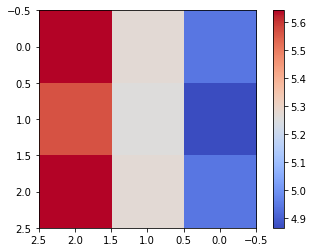

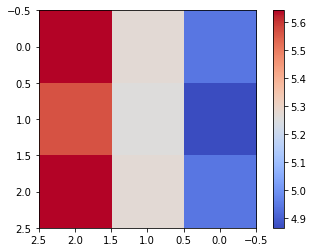

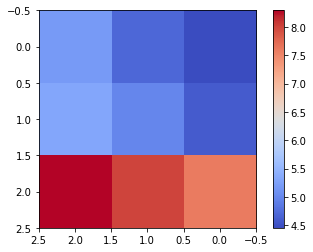

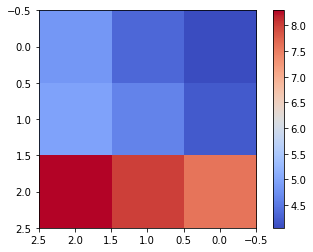

In [6]:
# show field at OP on each rotor disk

for t in range(nturbs):
    norm = mplcolors.Normalize(7.55, 8.25)
    cmap = plt.cm.get_cmap(name="coolwarm")
    plt.imshow(np.squeeze(flow_field_u[:,:,:,t,:,:]), cmap=cmap, norm=norm)
    plt.imshow(np.squeeze(flow_field_u[:,:,:,t,:,:]), cmap=cmap)
    ax = plt.gca()
    ax.invert_xaxis()
    plt.colorbar()
    plt.show()

In [ ]:
# power calculation (based on main floris branch)
fCp_interp = interp1d(wind_speed, power, fill_value=(0.0, 1.0), bounds_error=False)
rotor_area = np.pi * turbine_radius ** 2.0
inner_power = 0.5*rotor_area*fCp_interp(wind_speed)*generator_efficiency*np.array(wind_speed)**3
power_interp = interp1d(wind_speed, inner_power)
# omiting some lines here b/c assuming all turbines have same type

# ix_filter not implemented

# Compute the yaw effective velocity
pPs = np.ones_like(x_coord_rotated) * 1.88 # `turbine_library/nrel_5MW.yaml`
pW = pPs / 3.0  # Convert from pP to w
axis = tuple([3 + i for i in range(flow_field_u.ndim - 3)])
average_velocity = np.cbrt(np.mean(flow_field_u ** 3, axis=axis))
yaw_effective_velocity = ((air_density/1.225)**(1/3)) * average_velocity * cosd(yaw_angle) ** pW

# Power produced by a turbine adjusted for yaw and tilt. Value given in kW
p = 1.225 * power_interp(yaw_effective_velocity) / 1000.0 

# power for each turbine, total power
np.squeeze(p), np.sum(p)

In [ ]:
# TO DO (looks involved): hub-height velocity field calculation